# Genetic run analysis - 127 qubit backend

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quake.models.qsvm import genetic_v3 as genetic
from quake.models.qsvm.genetic_v3 import to_quantum
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from collections import OrderedDict
from qiskit.circuit import ParameterVector
from qiskit.circuit import QuantumCircuit
import pandas as pd
import csv
import pygad
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import StatevectorSimulator
from qiskit_machine_learning.kernels import FidelityStatevectorKernel

In [2]:
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")
useful_ft = [0, 5, 6, 8, 10, 12, 14, 15]
data_cv = data_cv[:, useful_ft]
suffix = "best_run"
genes = pd.read_csv("../../Output_genetic/"+suffix+"/genes" +
                 suffix+".csv", header=None, index_col=False).to_numpy()
df_kernels = pd.read_csv("../../Output_genetic/"+suffix +
                         "/kernels_flattened"+suffix+".csv", header=None, index_col=False)
accuracies = np.loadtxt("../../Output_genetic/" +
                        suffix+"/accuracy"+suffix+".txt")
sparsities = np.loadtxt("../../Output_genetic/" +
                        suffix+"/sparsity"+suffix+".txt")
df_fitnesses = np.loadtxt("../../Output_genetic/"+suffix +
                       "/fitness_values_iter_"+suffix+".txt")
stds = np.loadtxt("../../Output_genetic/"+suffix+"/offdiagonal_std_"+suffix+".txt")
# rand_idxs = pd.read_csv("../../Output_genetic/"+suffix+"/rand_indices" +
#                  suffix+".csv", header=None, index_col=False).to_numpy()[0]
fitnesses = df_fitnesses#.to_numpy()[:, 0]

In [3]:
gate_dict = OrderedDict(
    [
        ("single_non_parametric", ["Id", "X","SX"]),
        ("single_parametric", ["RZ", "RZ"]),
        ("two_non_parametric", ["ECR"]),
        ("two_parametric", []),
    ]
)
gates_per_qubits = 8
nb_qubits = 4
# useful_ft = [0, 5, 6, 8, 10, 12, 14, 15]
# useful_ft = [0, 1,2,5,6, 8, 10, 12, 14, 15, 17]
genes = [2,0,1,5,1,2,1,1,2,5,0,1,1,6,3,1,1,0,5,7,3,0,0,3,5,5,2,0,0,5,2,2,0,4,3,5,
         0,1,7,6,3,2,0,1,5,3,2,1,0,5,1,2,0,7,1,3,0,0,4,7,3,2,1,4,7,3,2,1,0,5,3,1,
         0,2,3,5,1,0,1,2,0,0,1,5,6,2,1,1,6,5,4,1,1,1,0,2,0,1,4,0,1,2,1,5,6,5,0,0,
         6,4,2,2,1,7,0,0,0,0,4,6,2,0,1,0,2,2,0,0,0,1,3,1,0,0,1,1,2,1,0,2,3,0,0,5,
         7,0,2,0,5,2,2,0,0,2,1,2,2,0,2,6
]
fmap, x_idxs = to_quantum(genes, gate_dict, len(useful_ft), gates_per_qubits, nb_qubits)
fmap.draw()
backend = StatevectorSimulator(precision='double')
clf = SVC(kernel="precomputed", C = 1)
qker = FidelityStatevectorKernel(feature_map=fmap)

qker_matrix_statevector = qker.evaluate(x_vec=data_cv[:, x_idxs])

In [6]:
fmap.draw()

┌────┐┌─────────────────┐      ┌────────────────────────────┐     »
q_0: ┤ √X ├┤ Rz(2π*x[3] - π) ├──────┤ Rz(2*asin(2*x[1] - 1) - π) ├─────»
     ├────┤└─────┬──────┬────┘┌─────┴────────────────────────────┴────┐»
q_1: ┤ √X ├──────┤0     ├─────┤ Rz(2*asin((2*x[0] - 1)*(2*x[5] - 1))) ├»
     ├───┬┘      │  Ecr │     └─────────────────┬────┬────────────────┘»
q_2: ┤ I ├───────┤1     ├───────────────────────┤ √X ├─────────────────»
     ├───┤       └──────┘                       └────┘                 »
q_3: ┤ X ├─────────────────────────────────────────────────────────────»
     └───┘                                                             »
«     ┌───────────────────────────────────────┐       ┌───┐       »
«q_0: ┤ Rz(2*asin((2*x[4] - 1)*(2*x[7] - 1))) ├───────┤ I ├───────»
«     ├───────────────────────────────────────┤       ├───┴┐      »
«q_1: ┤ Rz(2*asin((2*x[0] - 1)*(2*x[5] - 1))) ├───────┤ √X ├──────»
«     └────────────────┬──────┬───────────────┘       ├───┬┘      »
«q_2: ─────────────────┤1     ├───────────────────────┤ X ├───────»
«                      │  Ecr │                ┌──────┴───┴──────┐»
«q_3: ─────────────────┤0     ├────────────────┤ Rz(2π*x[4] - π) ├»
«                      └──────┘                └─────────────────┘»
«                 ┌───┐              ┌────┐ »
«q_0: ────────────┤ X ├──────────────┤ √X ├─»
«                 └───┘              └────┘ »
«q_1: ──────────────────────────────────────»
«     ┌────────────────────────────┐┌──────┐»
«q_2: ┤ Rz(2π*x[2]*(1 - x[2]) - π) ├┤1     ├»
«     └────────────────────────────┘│  Ecr │»
«q_3: ──────────────────────────────┤0     ├»
«                                   └──────┘»
«                          ┌─────────────────┐                             »
«q_0: ─────────────────────┤ Rz(2π*x[5] - π) ├─────────────────────────────»
«                          └─────────────────┘                     ┌──────┐»
«q_1: ─────────────────────────────────────────────────────────────┤0     ├»
«     ┌───────────────────────────────────────────────────────────┐│  Ecr │»
«q_2: ┤ Rz(1/π*(2π*x[0]*(1 - x[1]) - π)*(2π*x[1]*(1 - x[0]) - π)) ├┤1     ├»
«     └───────────────────────────┬────┬──────────────────────────┘└┬───┬─┘»
«q_3: ────────────────────────────┤ √X ├────────────────────────────┤ I ├──»
«                                 └────┘                            └───┘  »
«                                               
«q_0: ──────────────────────────────────────────
«     ┌────┐            ┌───┐                   
«q_1: ┤ √X ├────────────┤ I ├───────────────────
«     ├────┤┌───────────┴───┴────────────┐┌────┐
«q_2: ┤ √X ├┤ Rz(2π*x[0]*(1 - x[0]) - π) ├┤ √X ├
«     ├───┬┘└───────────┬────┬───────────┘└────┘
«q_3: ┤ X ├─────────────┤ √X ├──────────────────
«     └───┘             └────┘

In [140]:
df_kernels = pd.read_csv("../../Output_genetic/"+suffix +
                         "/kernels_flattened"+suffix+".csv", header=None, index_col=False).to_numpy()#.reshape(100, 100, -1)

In [141]:
# Reshape is needed
kernels = np.zeros((21, 100, 100))
for i in range(21):
    kernels[i] = df_kernels[i].reshape(100,100)


In [163]:
kernels[:, 25, 41].mean()

0.2982261904761905

In [164]:
qker_matrix_statevector[25,41]

0.26378864271449876

In [97]:
mean_matrix = np.mean(kernels, axis=0)

# Step 2: Compute the Frobenius norm of the difference from the mean matrix for each matrix
differences = np.array([np.linalg.norm(kernels[i] - mean_matrix, ord='fro') for i in range(kernels.shape[0])])

# Step 3: Identify the worst indices based on the largest differences
worst_indices = np.argsort(differences)[-18:]  # Get the indices of the top 5 most different matrices

# Print the indices and their corresponding differences
print("Worst indices (most different matrices):", worst_indices)
print("Differences for these indices:", differences[worst_indices])

Worst indices (most different matrices): [18  2 16 17 11  0 12 20  8 13 10  7  6  1 19  4  9  3]
Differences for these indices: [ 3.75971988  4.16887259  4.4625805   5.01947422  5.2711673   5.7173596
  5.75533783  5.77273213  5.91229495  6.00980664  6.14063487  6.5284513
  6.93483006  6.99395548  9.00927773  9.43885326 10.94375961 17.42976333]


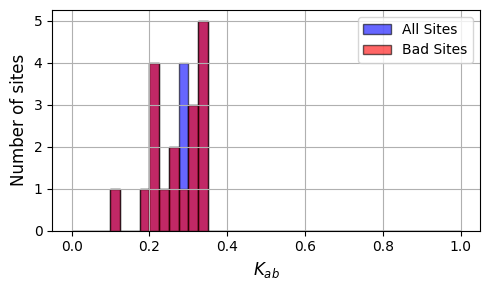

In [98]:
entry = []
entry_bad_sites = []

# Define indices and site lists
a = 5
b = 24
bad_sites = list(worst_indices)

# Collect data from kernels
for i in range(21):
    entry.append(kernels[i][a, b])
    if i in bad_sites:
        entry_bad_sites.append(kernels[i][a, b])

# Plotting the histograms
plt.figure(figsize=(5, 3))

# Histogram for all sites
plt.hist(entry, range=[0, 1], bins=40, alpha=0.6, label='All Sites', color='blue', edgecolor='black')

# Histogram for bad sites
plt.hist(entry_bad_sites, range=[0, 1], bins=40, alpha=0.6, label='Bad Sites', color='red', edgecolor='black')

# Adding labels and title
plt.xlabel(rf'$K_{{a b}}$', fontsize=12)
plt.ylabel('Number of sites', fontsize=12)

# Adding a legend
plt.legend(fontsize=10)

# Adding a grid
plt.grid(True)

# Adding tighter layout
plt.tight_layout()

# Show plot
plt.show()

In [118]:
kernels[4]

array([[1.      , 0.226625, 0.240625, ..., 0.038625, 0.23925 , 0.276625],
       [0.226625, 1.      , 0.290875, ..., 0.1175  , 0.39975 , 0.166375],
       [0.240625, 0.290875, 1.      , ..., 0.29    , 0.395875, 0.464125],
       ...,
       [0.038625, 0.1175  , 0.29    , ..., 1.      , 0.109375, 0.258625],
       [0.23925 , 0.39975 , 0.395875, ..., 0.109375, 1.      , 0.297125],
       [0.276625, 0.166375, 0.464125, ..., 0.258625, 0.297125, 1.      ]])

In [ ]:
kernels_s

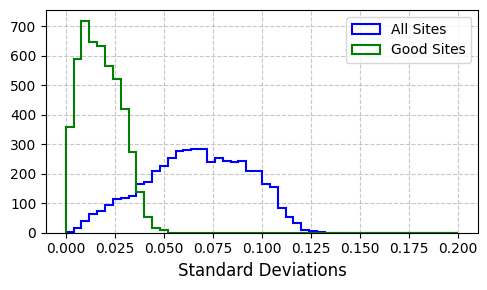

In [99]:
stds_all = np.zeros(4950)
stds_good = np.zeros(4950)
good_sites = []
for idx in np.arange(0, 21):
    if idx not in bad_sites:
        good_sites.append(idx)
counter = 0
for i in range(100):
    for j in range(i+1, 100):
        stds_all[counter] = np.std(kernels[:, i, j])
        stds_good[counter] = np.std(kernels[good_sites, i, j])
        counter += 1

plt.figure(figsize=(5, 3))

# Histogram for all standard deviations
plt.hist(stds_all, bins=50, histtype='step', label='All Sites', color='blue', linewidth=1.5, range = [0, 0.2])

# Histogram for good standard deviations
plt.hist(stds_good, bins=50, histtype='step', label='Good Sites', color='green', linewidth=1.5, range = [0, 0.2])

# Adding labels and title
plt.xlabel('Standard Deviations', fontsize=12)
# Adding a legend
plt.legend(fontsize=10)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding tighter layout
plt.tight_layout()

# Show plot
plt.show()

In [100]:
print(f"Avg. Fluctuations expected: {np.mean(stds_good)}")
print(f"Avg. Kernel standard deviation: {np.mean(stds)}")

Avg. Fluctuations expected: 0.01788339058916668
Avg. Kernel standard deviation: 0.24150691045948428


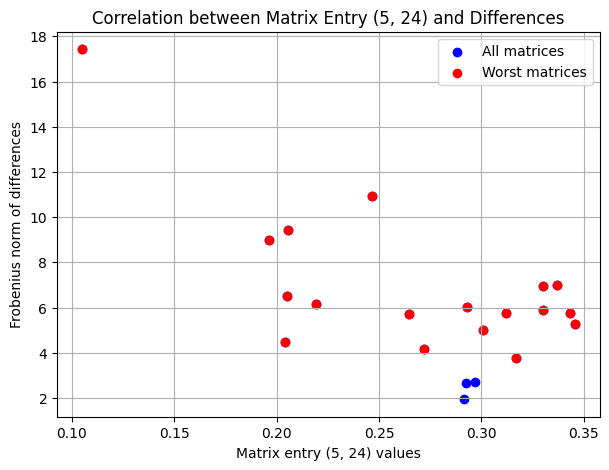

In [101]:
entry_values = kernels[:, a, b]

# Scatter plot of differences vs. entry values at (0, 0)
plt.figure(figsize=(7, 5))
plt.scatter(entry_values, differences, color='b', label='All matrices')
plt.scatter(entry_values[worst_indices], differences[worst_indices], color='r', label='Worst matrices')
plt.xlabel(f'Matrix entry ({a}, {b}) values')
plt.ylabel('Frobenius norm of differences')
plt.title(f'Correlation between Matrix Entry ({a}, {b}) and Differences')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
# kernels = df_kernels.to_numpy().reshape(21, 100,100)
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")
useful_ft = [0, 1,2,5,6, 8, 10, 12, 14, 15, 17]

data_cv = data_cv[:, useful_ft]

In [103]:
qsvm_connections = [
    [0,1,2,3],
    [4,15,22,21],
    [25,26,16,8],
    [13,12,11,10],
    [20, 33,39,38],
    [27,28,29,30],
    [32,36,51,50],
    [40,41,53,60],
    [49,48,47,46],
    # [71,58,57,56],
    [64,63,62,72],
    [70,69,68,67],
    [77,78,79,80],
    [82,83,84,85],
    [87,88,89,74],
    [95,94,90,75],
    [96,97,98,99],
    [119,118,110,100],
    [104,105,106,93],
    [116,115,114,113],
    [111,122,121,120],
    [126,125,124,123]
]

Let's load another (slightly harder) run

In [104]:
kernels_hard_df = np.load("../../Output_genetic/kernels_hard_attempt/kernels_nazca.npy")
kernels_hard = np.zeros((21, 100, 100))
for i in range(21):
    kernels_hard[i] = kernels_hard_df[i].reshape(100,100)


In [105]:
gate_dict = OrderedDict(
    [
        ("single_non_parametric", ["Id", "X", "SX"]),
        ("single_parametric", ["RZ"]),
        ("two_non_parametric", ["ECR"]),
        ("two_parametric", []),
    ]
)
gates_per_qubits = 9
nb_qubits = 4
useful_ft = [0, 1,2,5,6, 8, 10, 12, 14, 15, 17]
genes = [0,0,0,6,10,2,0,0,9,3,2,1,0,3,2,3,2,1,0,10,0,1,1,0,9,3,2,1,0,4,0,0,0,8,4,1,1,0,
         3,4,2,0,0,4,8,1,2,0,2,6,4,0,0,10,4,3,1,1,9,2,0,1,1,1,9,2,0,1,8,6,0,2,1,8,10,2,
         1,0,3,4,4,0,1,5,9,0,1,0,10,0,2,1,0,3,9,2,0,0,1,2,2,2,1,8,0,1,2,1,5,2,3,0,1,8,1,
         0,1,1,0,3,4,1,0,5,7,2,1,1,9,3,3,1,0,9,8,2,2,0,0,9,1,2,1,4,8,0,2,0,1,10,4,2,0,5,
         0,0,1,1,9,0,0,0,1,9,4,4,0,0,1,3,4,2,1,4,0,3,1,1,0,1]
fmap, x_idx = to_quantum(genes, gate_dict, len(useful_ft), gates_per_qubits, nb_qubits)
fmap.draw()

[0, 1, 2, 3] for qubit 2 I did nothing
[0, 1, 2, 3] for qubit 2 I did nothing
[0, 1, 2, 3] for qubit 2 I did nothing


┌───┐                   »
q_0: ──────────────────┤ I ├───────────────────»
                       ├───┴┐                  »
q_1: ──────────────────┤ √X ├──────────────────»
                       ├────┤                  »
q_2: ──────────────────┤ √X ├──────────────────»
     ┌─────────────────┴────┴─────────────────┐»
q_3: ┤ Rz(2*asin((2*x[0] - 1)*(2*x[10] - 1))) ├»
     └────────────────────────────────────────┘»
«                       ┌───┐                  »
«q_0: ──────────────────┤ I ├──────────────────»
«     ┌─────────────────┴───┴─────────────────┐»
«q_1: ┤ Rz(2*asin((2*x[0] - 1)*(2*x[4] - 1))) ├»
«     └─────────────────┬───┬─────────────────┘»
«q_2: ──────────────────┤ I ├──────────────────»
«                       ├───┤                  »
«q_3: ──────────────────┤ X ├──────────────────»
«                       └───┘                  »
«                                 ┌────┐                           ┌───┐ »
«q_0: ────────────────────────────┤ √X ├───────────────────────────┤ I ├─»
«                                 ├───┬┘                           ├───┴┐»
«q_1: ────────────────────────────┤ X ├────────────────────────────┤ √X ├»
«                                 ├───┤                            ├────┤»
«q_2: ────────────────────────────┤ I ├────────────────────────────┤ √X ├»
«     ┌───────────────────────────┴───┴───────────────────────────┐├────┤»
«q_3: ┤ Rz(1/π*(2π*x[2]*(1 - x[9]) - π)*(2π*x[9]*(1 - x[2]) - π)) ├┤ √X ├»
«     └───────────────────────────────────────────────────────────┘└────┘»
«                ┌──────┐                       ┌────┐                  »
«q_0: ───────────┤0     ├───────────────────────┤ √X ├──────────────────»
«                │  Ecr │                       ├───┬┘            ┌───┐ »
«q_1: ───────────┤1     ├───────────────────────┤ I ├─────────────┤ X ├─»
«     ┌──────────┴──────┴──────────┐┌───────────┴───┴────────────┐└───┘ »
«q_2: ┤ Rz(2π*x[8]*(1 - x[1]) - π) ├┤ Rz(2π*x[9]*(1 - x[9]) - π) ├──────»
«     └───────────┬────┬───────────┘└───────────┬───┬────────────┘┌────┐»
«q_3: ────────────┤ √X ├────────────────────────┤ I ├─────────────┤ √X ├»
«                 └────┘                        └───┘             └────┘»
«     ┌──────┐                            ┌───┐                            »
«q_0: ┤0     ├────────────────────────────┤ X ├────────────────────────────»
«     │  Ecr │                            ├───┴┐                           »
«q_1: ┤1     ├────────────────────────────┤ √X ├───────────────────────────»
«     └──────┘                            └────┘                           »
«q_2: ─────────────────────────────────────────────────────────────────────»
«      ┌───┐  ┌───────────────────────────────────────────────────────────┐»
«q_3: ─┤ I ├──┤ Rz(1/π*(2π*x[0]*(1 - x[1]) - π)*(2π*x[1]*(1 - x[0]) - π)) ├»
«      └───┘  └───────────────────────────────────────────────────────────┘»
«     ┌───┐        
«q_0: ┤ I ├────────
«     ├───┤┌──────┐
«q_1: ┤ I ├┤0     ├
«     └───┘│  Ecr │
«q_2: ─────┤1     ├
«          └──────┘
«q_3: ─────────────
«

In [106]:
mean_matrix = np.mean(kernels_hard, axis=0)

# Step 2: Compute the Frobenius norm of the difference from the mean matrix for each matrix
differences = np.array([np.linalg.norm(kernels_hard[i] - mean_matrix, ord='fro') for i in range(kernels_hard.shape[0])])

# Step 3: Identify the worst indices based on the largest differences
worst_indices = np.argsort(differences)[-4:]  # Get the indices of the top 5 most different matrices

# Print the indices and their corresponding differences
print("Worst indices (most different matrices):", worst_indices)
print("Differences for these indices:", differences[worst_indices])

Worst indices (most different matrices): [17  9 19 10]
Differences for these indices: [14.66377097 15.19018942 18.04872718 23.21504029]


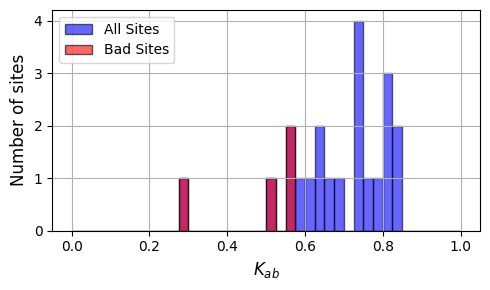

In [107]:
entry = []
entry_bad_sites = []

# Define indices and site lists
a = 5
b = 24
bad_sites = list(worst_indices)

# Collect data from kernels
for i in range(21):
    entry.append(kernels_hard[i][a, b])
    if i in bad_sites:
        entry_bad_sites.append(kernels_hard[i][a, b])

# Plotting the histograms
plt.figure(figsize=(5, 3))

# Histogram for all sites
plt.hist(entry, range=[0, 1], bins=40, alpha=0.6, label='All Sites', color='blue', edgecolor='black')

# Histogram for bad sites
plt.hist(entry_bad_sites, range=[0, 1], bins=40, alpha=0.6, label='Bad Sites', color='red', edgecolor='black')

# Adding labels and title
plt.xlabel(rf'$K_{{a b}}$', fontsize=12)
plt.ylabel('Number of sites', fontsize=12)

# Adding a legend
plt.legend(fontsize=10)

# Adding a grid
plt.grid(True)

# Adding tighter layout
plt.tight_layout()

# Show plot
plt.show()

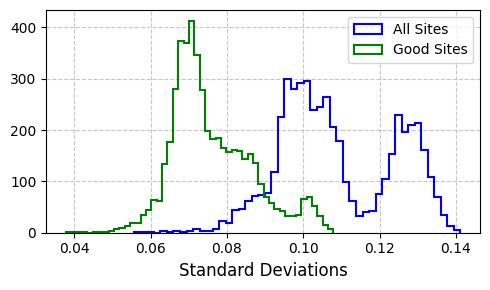

In [108]:
stds_all = np.zeros(4950)
stds_good = np.zeros(4950)
good_sites = []
for idx in np.arange(0, 21):
    if idx not in bad_sites:
        good_sites.append(idx)
counter = 0
for i in range(100):
    for j in range(i+1, 100):
        stds_all[counter] = np.std(kernels_hard[:, i, j])
        stds_good[counter] = np.std(kernels_hard[good_sites, i, j])
        counter += 1

plt.figure(figsize=(5, 3))

# Histogram for all standard deviations
plt.hist(stds_all, bins=50, histtype='step', label='All Sites', color='blue', linewidth=1.5)

# Histogram for good standard deviations
plt.hist(stds_good, bins=50, histtype='step', label='Good Sites', color='green', linewidth=1.5)

# Adding labels and title
plt.xlabel('Standard Deviations', fontsize=12)
# Adding a legend
plt.legend(fontsize=10)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding tighter layout
plt.tight_layout()

# Show plot
plt.show()

In [109]:
print(f"Avg. Fluctuations expected: {np.mean(stds_good)}")
print(f"Avg. Kernel standard deviation: {np.mean(stds)}")

Avg. Fluctuations expected: 0.07607359363314706
Avg. Kernel standard deviation: 0.24150691045948428
